In [ ]:
!sudo apt-get update
!pip install pygame
!apt-get install -y xvfb x11-utils
!pip install pyvirtualdisplay==0.2.*


!pip install xvfbwrapper
!pip install pyvirtualdisplay
!pip install piglet
from pyvirtualdisplay import Display
display=Display(visible=0, size=(1400, 900))
display.start()

#added to install gym_maze library
!git clone https://github.com/MattChanTK/gym-maze
%cd gym-maze 
%run setup.py install

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [73.9 kB]
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:12 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:13 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:14 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 k

zip_safe flag not set; analyzing archive contents...
gym_maze.envs.__pycache__.maze_view_2d.cpython-37: module references __file__


creating dist
creating 'dist/gym_maze-0.4-py3.7.egg' and adding 'build/bdist.linux-x86_64/egg' to it
removing 'build/bdist.linux-x86_64/egg' (and everything under it)
Processing gym_maze-0.4-py3.7.egg
creating /usr/local/lib/python3.7/dist-packages/gym_maze-0.4-py3.7.egg
Extracting gym_maze-0.4-py3.7.egg to /usr/local/lib/python3.7/dist-packages
Adding gym-maze 0.4 to easy-install.pth file

Installed /usr/local/lib/python3.7/dist-packages/gym_maze-0.4-py3.7.egg
Processing dependencies for gym-maze==0.4
Searching for numpy==1.19.5
Best match: numpy 1.19.5
Adding numpy 1.19.5 to easy-install.pth file
Installing f2py script to /usr/local/bin
Installing f2py3 script to /usr/local/bin
Installing f2py3.7 script to /usr/local/bin

Using /usr/local/lib/python3.7/dist-packages
Searching for pygame==2.1.0
Best match: pygame 2.1.0
Adding pygame 2.1.0 to easy-install.pth file

Using /usr/local/lib/python3.7/dist-packages
Searching for gym==0.17.3
Best match: gym 0.17.3
Adding gym 0.17.3 to easy-in

In [ ]:
import gym
import gym_maze
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image
import sys

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

env = gym.make("maze-random-10x10-v0")#needs to be changed larger

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pygame 2.1.0 (SDL 2.0.16, Python 3.7.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


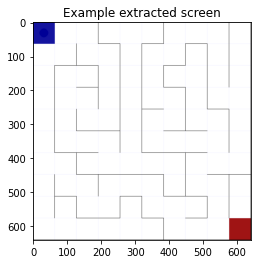

In [ ]:
env.reset()
screen= env.render()
#print(obv.shape)
plt.figure()
plt.imshow(screen)
plt.title('Example extracted screen')
plt.show()



In [ ]:
MAZE_SIZE = tuple((env.observation_space.high + np.ones(env.observation_space.shape)).astype(int))
NUM_BUCKETS = MAZE_SIZE  # one bucket per grid
STATE_BOUNDS = list(zip(env.observation_space.low, env.observation_space.high))
NUM_ACTIONS = env.action_space.n  # ["N", "S", "E", "W"]
MAX_T = np.prod(MAZE_SIZE, dtype=int) * 100
SOLVED_T = np.prod(MAZE_SIZE, dtype=int)
q_table = np.zeros((NUM_BUCKETS[0],NUM_BUCKETS[1],NUM_ACTIONS), dtype=float)


In [ ]:
GAMMA = 0.999 #
EPS_START =0.9 #EPS determine if random policy or best existing policy
EPS_END = 0.05
EPS_DECAY = 200


steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY) #
    steps_done += 1
    if sample > eps_threshold:
        #with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
          return int(np.argmax(q_table[state])) #policy_net(state).max(1)[1].view(1, 1)
    else:
        return env.action_space.sample()#torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)
        #possibility of random value returned based on EPS values
        #otherwhise action is selected with greatest expected rewaed




In [ ]:
episode_durations = []

def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
   

In [ ]:
def state_to_bucket(state):
    bucket_indice = []
    for i in range(len(state)):
        if state[i] <= STATE_BOUNDS[i][0]:
            bucket_index = 0
        elif state[i] >= STATE_BOUNDS[i][1]:
            bucket_index = NUM_BUCKETS[i] - 1
        else:
            # Mapping the state bounds to the bucket array
            bound_width = STATE_BOUNDS[i][1] - STATE_BOUNDS[i][0]
            offset = (NUM_BUCKETS[i]-1)*STATE_BOUNDS[i][0]/bound_width
            #print(offset)
            scaling = (NUM_BUCKETS[i]-1)/bound_width
            bucket_index = int(round(scaling*state[i] - offset))
        bucket_indice.append(bucket_index)
    return tuple(bucket_indice)


In [ ]:
MIN_LEARNING_RATE = 0.2
DECAY_FACTOR = np.prod(MAZE_SIZE, dtype=float) / 10.0
def get_learning_rate(t):
    return max(MIN_LEARNING_RATE, min(0.8, 1.0 - math.log10((t+1)/DECAY_FACTOR)))


Episode  0  finshed after  492  time steps with total reward  0.5079999999999996
Episode  1  finshed after  1277  time steps with total reward  -0.27699999999997016
Episode  2  finshed after  384  time steps with total reward  0.6159999999999997
Episode  3  finshed after  80  time steps with total reward  0.9199999999999999
Episode  4  finshed after  312  time steps with total reward  0.6879999999999997
Episode  5  finshed after  84  time steps with total reward  0.9159999999999999
Episode  6  finshed after  151  time steps with total reward  0.8489999999999999
Episode  7  finshed after  83  time steps with total reward  0.9169999999999999
Episode  8  finshed after  489  time steps with total reward  0.5109999999999997
Episode  9  finshed after  44  time steps with total reward  0.956
Episode  10  finshed after  89  time steps with total reward  0.9109999999999999
Episode  11  finshed after  36  time steps with total reward  0.964
Episode  12  finshed after  38  time steps with total r

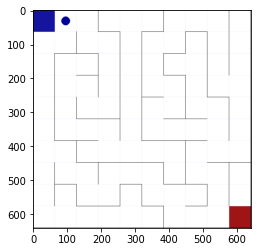

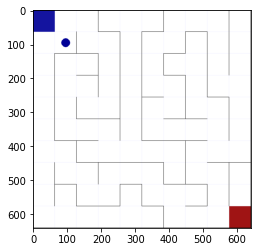

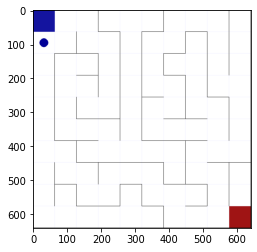

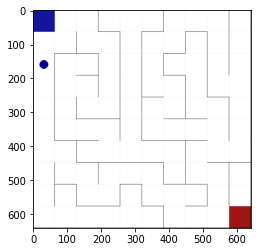

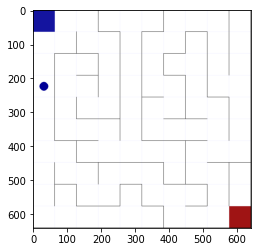

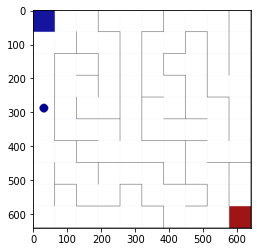

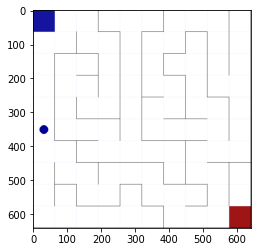

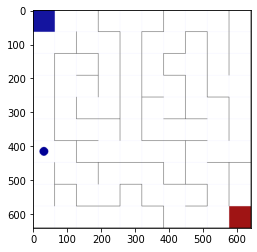

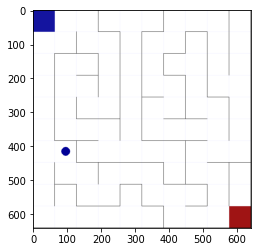

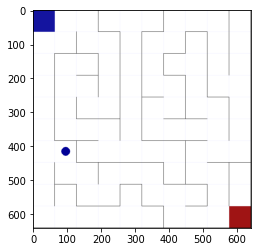

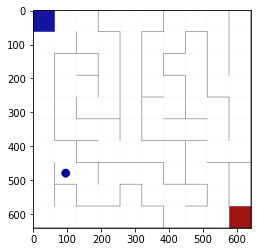

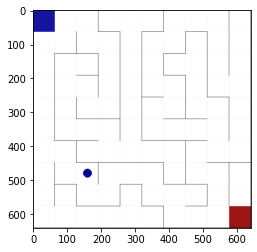

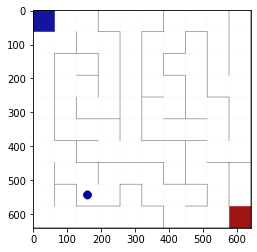

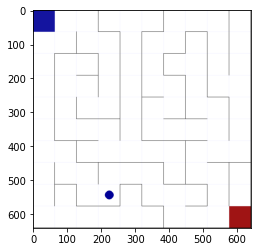

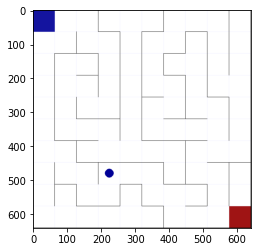

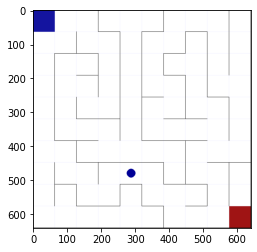

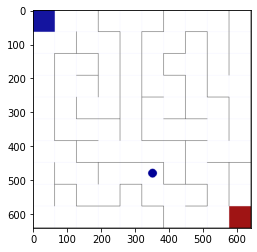

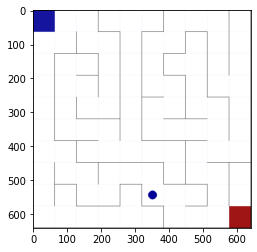

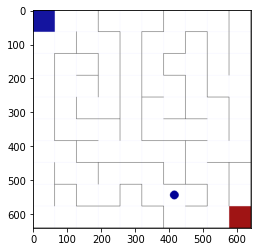

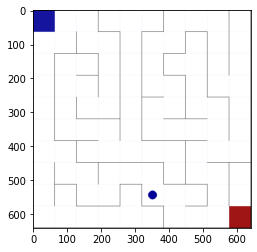

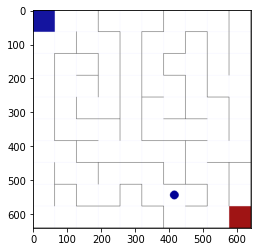

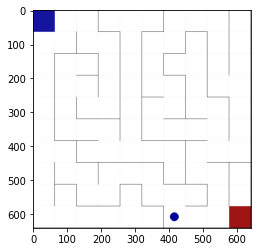

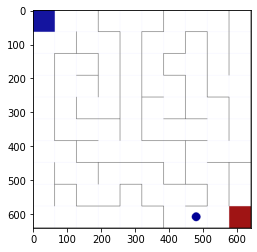

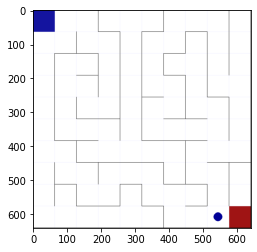

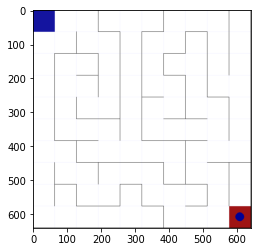

Episode  1999  finshed after  24  time steps with total reward  0.976


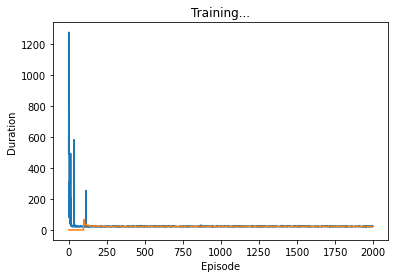

In [ ]:
num_episodes =2000

learning_rate = get_learning_rate(0)
discount_factor = 0.99

for i_episode in range(num_episodes):
# Reset the environment
  obv = env.reset()
  total_reward = 0
  state_0 = state_to_bucket(obv)

  for t in range(MAX_T):
     action = select_action(state_0)
     obv, reward, done, _ = env.step(action)
     state = state_to_bucket(obv)
     total_reward += reward
     best_q = np.amax(q_table[state])
     q_table[state_0 + (action,)] += learning_rate * (reward + discount_factor * (best_q) - q_table[state_0 + (action,)])
     state_0 = state
     #env.render()
     if i_episode==num_episodes-1:
       plt.figure()
       plt.imshow(env.render())
       plt.pause(0.0001)  # pause a bit so that plots are updated
     if env.is_game_over():

       sys.exit()
     if done:
       print("Episode ",i_episode," finshed after ",t," time steps with total reward ",total_reward)
       episode_durations.append(t)
       break
     elif t >= MAX_T - 1: 
       print("Episode ",i_episode," timed out at ",t," total reward ",total_reward)
       episode_durations.append(t)
     learning_rate = get_learning_rate(i_episode)
plot_durations()